# Several Buoys data analysis

The idea is to see info from many buoys and see what information we can get from them

In [1]:
from ndbc_api import NdbcApi
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import folium

api = NdbcApi()

Get the stations and filter them to only show the buoys

In [2]:
# get all stations and some metadata as a Pandas DataFrame
stations_df = api.stations()

buoy_df = stations_df[stations_df['Type'] == 'buoy']



In [3]:
# Only include buoys with meteorology data and clean the data of unused columns

buoy_df = buoy_df[buoy_df['Includes Meteorology'] == True]

buoy_df = buoy_df.drop(columns=['Type', 'Includes Meteorology', 'Includes Currents',
                       'Includes Water Quality', 'DART Program']).reset_index(drop=True)


buoy_df

Station     Lat     Lon Elevation  \
0     13001  12.000 -23.000       0.0   
1     13002  21.000 -23.000       0.0   
2     13008  15.000 -38.000       0.0   
3     13009   8.000 -38.000       0.0   
4     14048  -8.000  65.000       0.0   
..      ...     ...     ...       ...   
268   62163  47.550  -8.470       0.0   
269   62442  49.000 -16.500      <NA>   
270   64045  59.150 -11.790       0.0   
271   cbcm2  39.223 -76.540       0.0   
272   ssbn7  33.838 -78.484       0.0   

                                        Name  \
0                               NE Extension   
1                               NE Extension   
2                                     Reggae   
3                                    Lambada   
4                                              
..                                       ...   
268                            Brittany Buoy   
269                                      Pap   
270                                  K5 Buoy   
271        Curtis Bay Ch. Entrance (8574837)   
272  Sunset Beach Nearshore Waves (SUN2WAVE)   

                                                 Owner                 Program  
0    Prediction and Research Moored Array in the At...  International Partners  
1    Prediction and Research Moored Array in the At...  International Partners  
2    Prediction and Research Moored Array in the At...  International Partners  
3    Prediction and Research Moored Array in the At...  International Partners  
4    Research Moored Array for African-Asian-Austra...  International Partners  
..                                                 ...                     ...  
268                                      UK Met Office  International Partners  
269                                      UK Met Office  International Partners  
270                                      UK Met Office  International Partners  
271                                     NOAA NOS PORTS              NOS/CO-OPS  
272                                              CORMP           IOOS Partners  

[273 rows x 7 columns]

In [4]:
buoy_df['Elevation'].value_counts()

Elevation
0.0       198
176.0      17
174.0      13
183.0       7
177.0       6
75.0        3
156.0       2
217.0       1
175.0       1
332.0       1
219.0       1
196.0       1
174.2       1
30.0        1
177.43      1
Name: count, dtype: int64

In [5]:

# Create a GeoDataFrame from the buoy locations
buoy_df['geometry'] = buoy_df.apply(lambda row: Point(row['Lon'], row['Lat']), axis=1)
buoys_gdf = gpd.GeoDataFrame(buoy_df, geometry='geometry')

# Load the GeoJSON file
oceans_gdf = gpd.read_file('5oceansByNick.geojson')

# Ensure both GeoDataFrames are using the same coordinate reference system (CRS)
# If the oceans GeoDataFrame is in a different projection, you may need to convert it
buoys_gdf.crs = oceans_gdf.crs

# Perform a spatial join to find which ocean each buoy belongs to
buoy_df = gpd.sjoin(buoys_gdf, oceans_gdf, how="left", predicate='within')

# The resulting DataFrame will have an additional column with ocean names
print(buoy_df[['Lat', 'Lon', 'name']])  # Shows latitude, longitude and corresponding ocean name


        Lat     Lon            name
0    12.000 -23.000  Atlantic Ocean
1    21.000 -23.000  Atlantic Ocean
2    15.000 -38.000  Atlantic Ocean
3     8.000 -38.000  Atlantic Ocean
4    -8.000  65.000    Indian Ocean
..      ...     ...             ...
268  47.550  -8.470  Atlantic Ocean
269  49.000 -16.500  Atlantic Ocean
270  59.150 -11.790  Atlantic Ocean
271  39.223 -76.540  Atlantic Ocean
272  33.838 -78.484  Atlantic Ocean

[273 rows x 3 columns]


In [6]:
# Drop unnecessary columns, and change name for Ocean

buoy_df = buoy_df.drop(columns=['geometry', 'index_right'])
buoy_df = buoy_df.rename(columns={'name': 'Ocean'})

buoy_df.head()

Station   Lat   Lon Elevation          Name  \
0   13001  12.0 -23.0       0.0  NE Extension   
1   13002  21.0 -23.0       0.0  NE Extension   
2   13008  15.0 -38.0       0.0        Reggae   
3   13009   8.0 -38.0       0.0       Lambada   
4   14048  -8.0  65.0       0.0                 

                                               Owner                 Program  \
0  Prediction and Research Moored Array in the At...  International Partners   
1  Prediction and Research Moored Array in the At...  International Partners   
2  Prediction and Research Moored Array in the At...  International Partners   
3  Prediction and Research Moored Array in the At...  International Partners   
4  Research Moored Array for African-Asian-Austra...  International Partners   

            Ocean  
0  Atlantic Ocean  
1  Atlantic Ocean  
2  Atlantic Ocean  
3  Atlantic Ocean  
4    Indian Ocean

In [7]:
# Create a Folium map centered around the average of the buoy coordinates
m = folium.Map(location=[buoy_df['Lat'].mean(), buoy_df['Lon'].mean()], zoom_start=2)

# Add ocean polygons from GeoJSON
folium.GeoJson(
    oceans_gdf.__geo_interface__,
    style_function=lambda feature: {
        'fillColor': 'lightblue',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.5,
    }
).add_to(m)

# Define a color mapping for each ocean
ocean_colors = {
    'Atlantic Ocean': 'blue',
    'Pacific Ocean America': 'green',
    'Indian Ocean': 'red',
    'Southern Ocean': 'purple',
    'Pacific Ocean Asia': 'green'
}

# Add buoy locations to the map
for idx, row in buoy_df.iterrows():
    # Get the color for the current ocean, default to orange if not found
    icon_color = ocean_colors.get(row['Ocean'], 'orange')
    
    folium.Marker(
        location=(row['Lat'], row['Lon']),
        popup=f'Buoy {row["Station"]}\n ({row["Lat"]}, {row["Lon"]})\n{row["Ocean"]}',
        icon=folium.Icon(color=icon_color)
    ).add_to(m)
# Save the map to an HTML file
m.save('buoy_ocean_map.html')

# Display the map
m

Buoy locations are established and the data seems to be clean. Now i want to know how the data in the buoys behave between them (i terms of meteorology)

In [8]:
# Function to be implemented by you
def station_data_check(ocean, station):
    
    print(api.available_realtime(station_id=station))
    print(api.available_historical(station_id=station))
    
    df = api.get_data(
        station_id=station,
        mode='stdmet',
        start_time='2020-09-01',
        end_time='2024-09-02',
    )
    # Removing columns where all values are NaN
    #df = df.dropna(axis=1, how='all')

    print(df)

In [9]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Get unique ocean values, excluding NaN
ocean_options = [o for o in buoy_df['Ocean'].unique() if pd.notna(o)]

# Create ocean dropdown
ocean_dropdown = widgets.Dropdown(
    options=ocean_options,
    description='Ocean:',
    disabled=False,
)

# Create station dropdown (initially empty)
station_dropdown = widgets.Dropdown(
    options=[],
    description='Station:',
    disabled=False,
)

# Define the callback function
def update_stations(*args):
    selected_ocean = ocean_dropdown.value
    filtered_stations = buoy_df[buoy_df['Ocean'] == selected_ocean]['Station'].unique()
    station_dropdown.options = filtered_stations

# Link the callback to the ocean dropdown
ocean_dropdown.observe(update_stations, names='value')

# Initial update of stations
update_stations()

# Create a container for the widgets
widget_box = widgets.VBox([ocean_dropdown, station_dropdown])

# Create a button widget
run_button = widgets.Button(
    description='Run Check',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to run station_data_check',
    icon='check' # (optional) icon name from the Font Awesome library
)


# Create an output widget to display results
output = widgets.Output()

# Define the button click event handler
def on_button_clicked(b):
    output.clear_output(wait=True)
    with output:
        station_data_check(ocean_dropdown.value, station_dropdown.value)


# Link the click event to the button
run_button.on_click(on_button_clicked)

# Create a container for the widgets, now including the button
widget_box = widgets.VBox([ocean_dropdown, station_dropdown, run_button])


# Display the widgets
display(widget_box)
display(output)

Output()

Error fetching data for station 22101: NDBC API: No data was returned for station_ids ['22101'] and modes ['stdmet']
Error fetching data for station 22102: NDBC API: No data was returned for station_ids ['22102'] and modes ['stdmet']
Error fetching data for station 22103: NDBC API: No data was returned for station_ids ['22103'] and modes ['stdmet']
Error fetching data for station 22104: NDBC API: No data was returned for station_ids ['22104'] and modes ['stdmet']
Error fetching data for station 22105: NDBC API: No data was returned for station_ids ['22105'] and modes ['stdmet']
Error fetching data for station 22106: NDBC API: No data was returned for station_ids ['22106'] and modes ['stdmet']
Error fetching data for station 22107: NDBC API: No data was returned for station_ids ['22107'] and modes ['stdmet']
Error fetching data for station 22108: NDBC API: No data was returned for station_ids ['22108'] and modes ['stdmet']


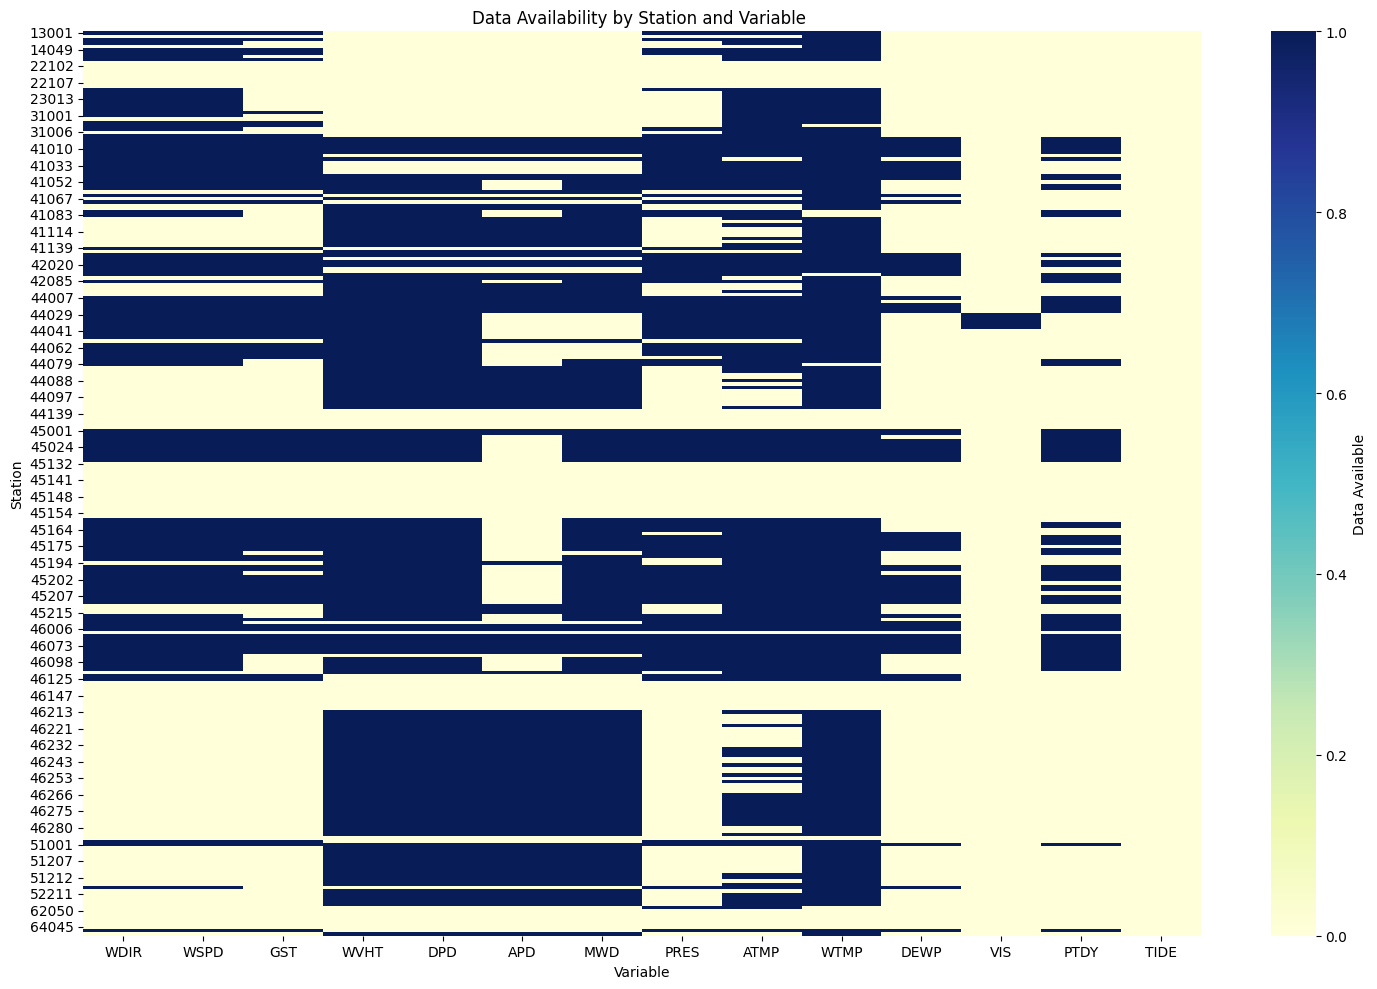

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming buoy_df is your DataFrame with the list of buoys in the 'Station' column
stations = buoy_df['Station'].unique()  # Take only the first 20 stations

# List of variables to check
variables = ['WDIR', 'WSPD', 'GST', 'WVHT', 'DPD', 'APD', 'MWD', 'PRES', 'ATMP', 'WTMP', 'DEWP', 'VIS', 'PTDY', 'TIDE']

# Create a DataFrame to store availability (1 for available, 0 for not available)
availability = pd.DataFrame(index=stations, columns=variables, dtype=int)
availability.fillna(0, inplace=True)  # Fill with zeros initially

# Fill the availability DataFrame
for station in stations:
    try:
        # Fetch data for each station
        df = api.get_data(
            station_id=station,
            mode='stdmet',
            start_time='2018-09-01',
            end_time='2024-09-02',
        )
        
        for var in variables:
            if var in df.columns and not df[var].isna().all():
                availability.loc[station, var] = 1
    except Exception as e:
        print(f"Error fetching data for station {station}: {str(e)}")
        # No need to fill with zeros as it's already done

# Ensure all data is numeric
availability = availability.astype(int)

# Create a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(availability, cmap='YlGnBu', cbar_kws={'label': 'Data Available'})
plt.title('Data Availability by Station and Variable ')
plt.ylabel('Station')
plt.xlabel('Variable')
plt.tight_layout()
plt.show()


None of the data has TIDE, only  a few has VIS.

In [11]:
buoy_df["Ocean"].unique()

array(['Atlantic Ocean', 'Indian Ocean', 'Pacific Ocean Asia', nan,
       'Pacific Ocean America'], dtype=object)

# Analysis by ocean

There is a lot of info, so lets try to make music in the ocean with less number of buoys first. To do so, we are going to start with the Indian Ocean.
We will plot the info see what info is available using the heatmap as before, and analizing the amount of data.

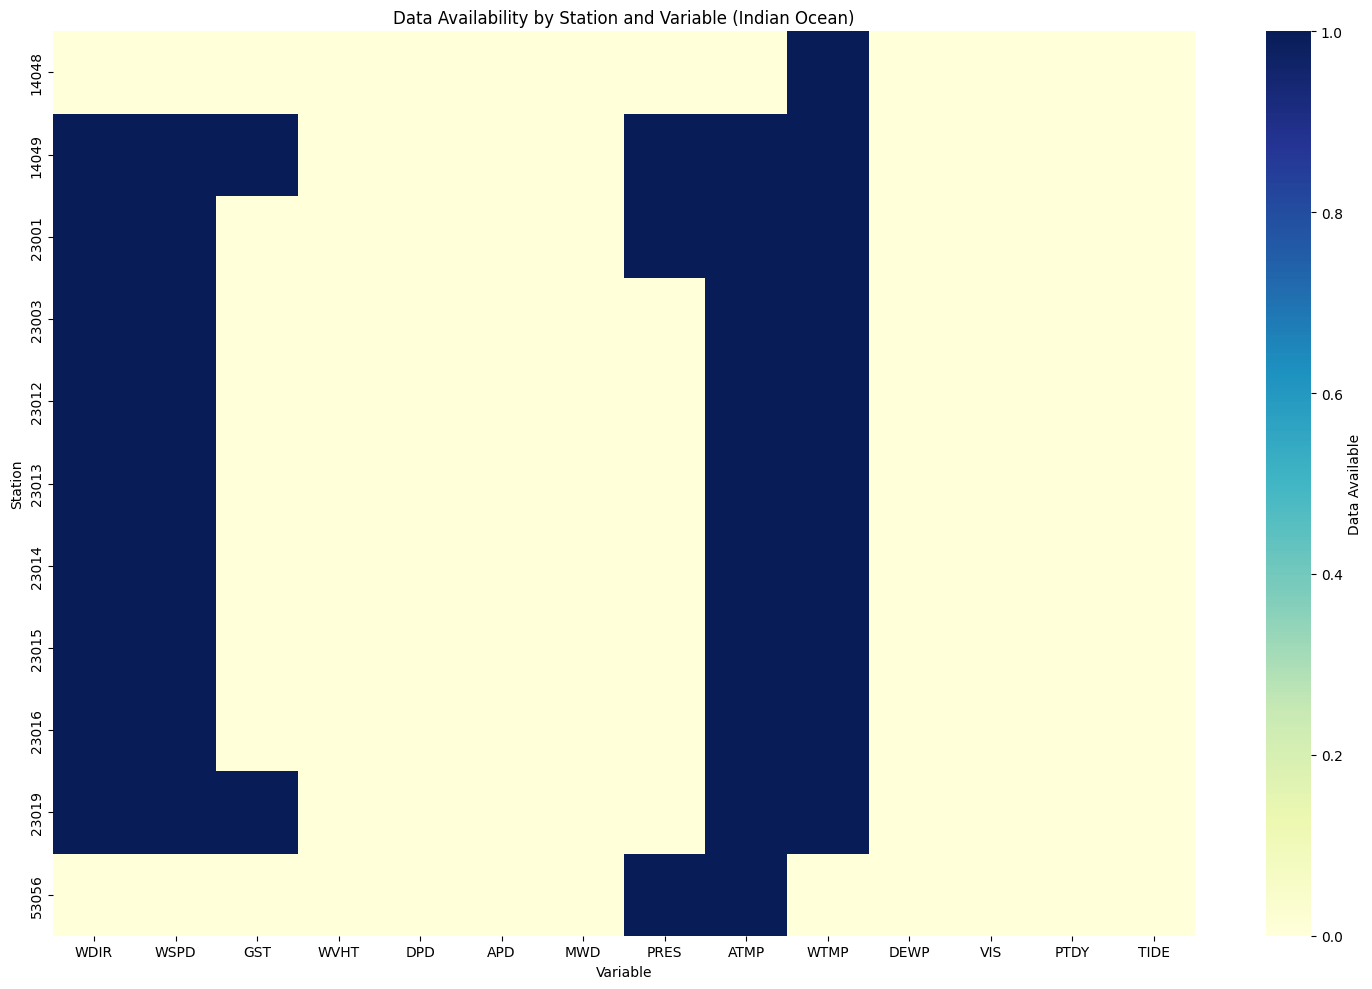

In [12]:
# Assuming buoy_df is your DataFrame with the list of buoys and 'Ocean' column
indian_ocean_stations = buoy_df[buoy_df['Ocean'] == 'Indian Ocean']['Station'].unique()

# List of variables to check
variables = ['WDIR', 'WSPD', 'GST', 'WVHT', 'DPD', 'APD', 'MWD', 'PRES', 'ATMP', 'WTMP', 'DEWP', 'VIS', 'PTDY', 'TIDE']

# Create a DataFrame to store availability (1 for available, 0 for not available)
availability = pd.DataFrame(index=indian_ocean_stations, columns=variables, dtype=int)
availability.fillna(0, inplace=True)  # Fill with zeros initially

# List to store DataFrames for each station
station_data_list = []

# Fill the availability DataFrame and store station data
for station in indian_ocean_stations:
    try:
        # Fetch data for each station
        df = api.get_data(
            station_id=station,
            mode='stdmet',
            start_time='2018-09-01',
            end_time='2024-09-07',
        )
        
        # Store the DataFrame in the list
        station_data_list.append(df)
        
        for var in variables:
            if var in df.columns and not df[var].isna().all():
                availability.loc[station, var] = 1
    except Exception as e:
        print(f"Error fetching data for station {station}: {str(e)}")
        # Add an empty DataFrame to maintain the order
        station_data_list.append(pd.DataFrame())

# Ensure all data is numeric
availability = availability.astype(int)

# Create a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(availability, cmap='YlGnBu', cbar_kws={'label': 'Data Available'})
plt.title('Data Availability by Station and Variable (Indian Ocean)')
plt.ylabel('Station')
plt.xlabel('Variable')
plt.tight_layout()
plt.show()

# Now you have all the data stored in station_data_list
# You can access it later without calling the API again

So for the indian ocean we have data on 
- Wind direction
- Wind Speed
- Gust - Gust: (Abbrev. G) - A rapid fluctuation of wind speed with variations of 10 knots or more between peaks and lulls.
- Preasure
- Air temperature
- Wind temperature 

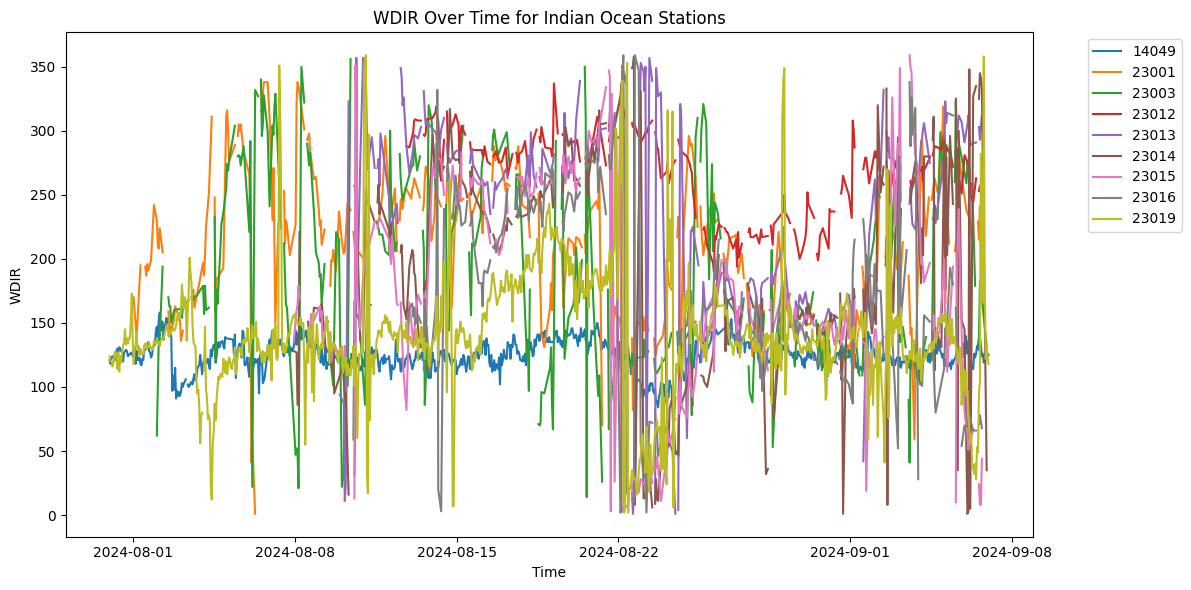

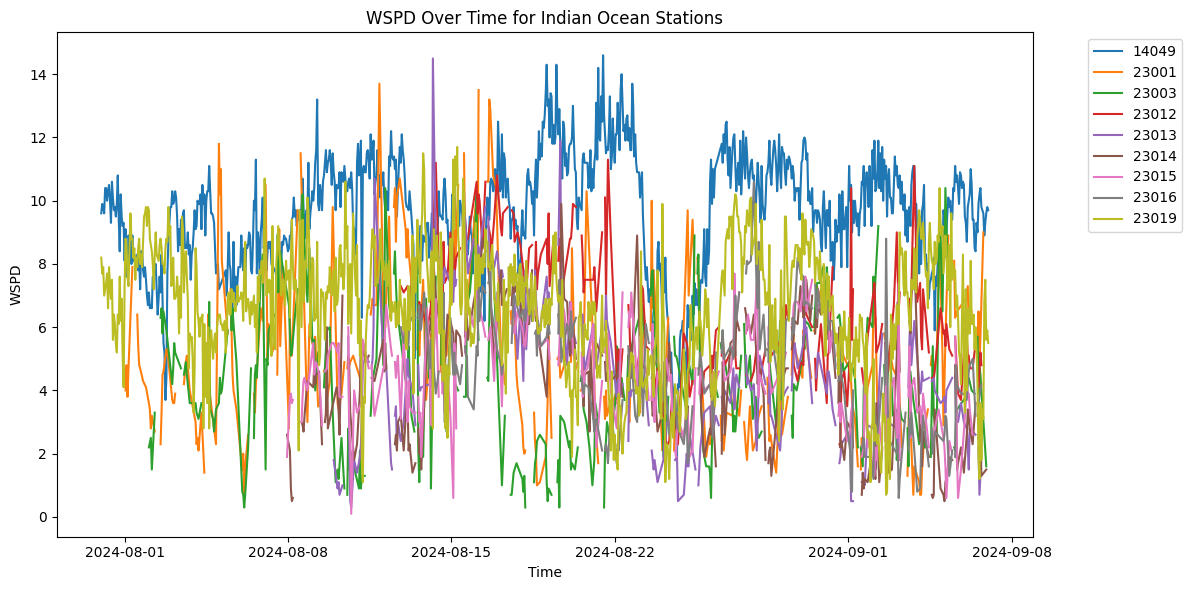

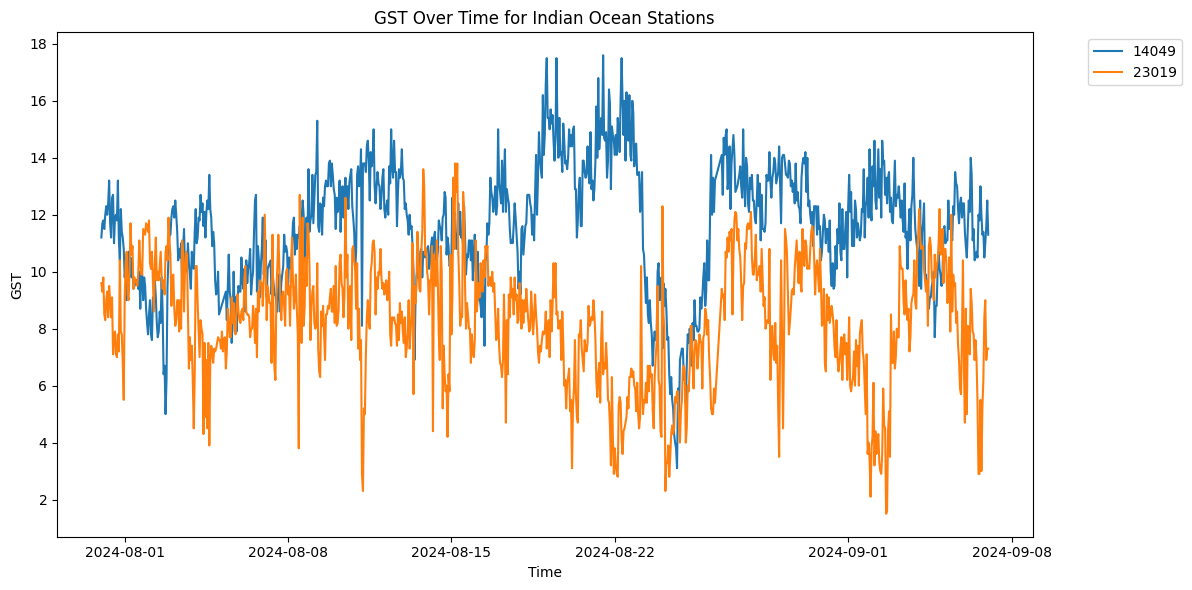

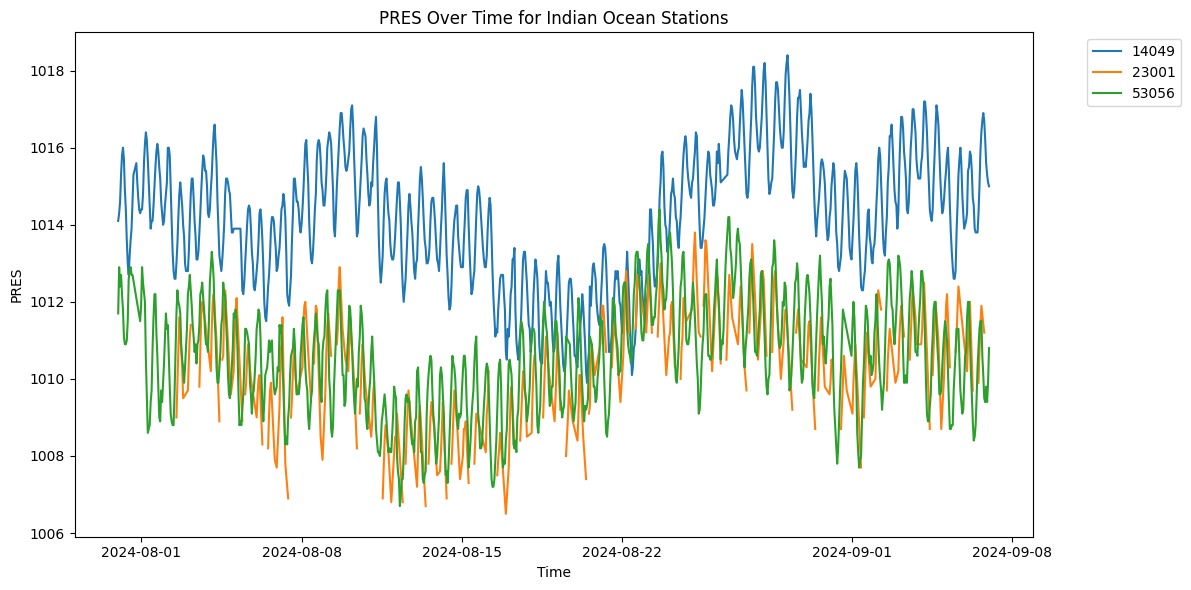

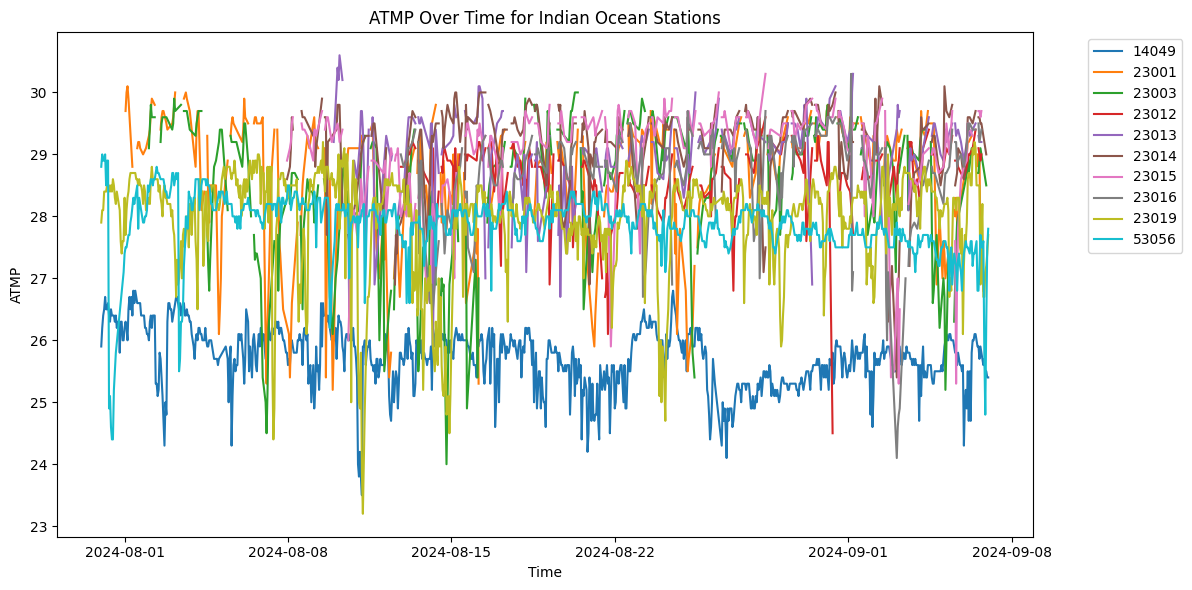

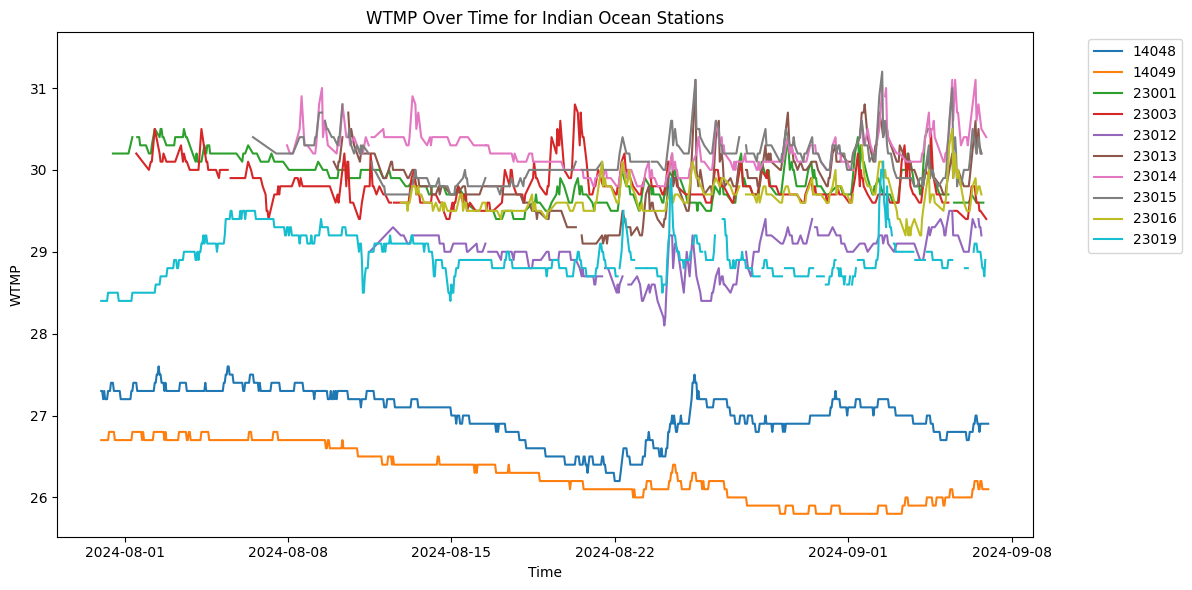

<Figure size 1500x1000 with 0 Axes>

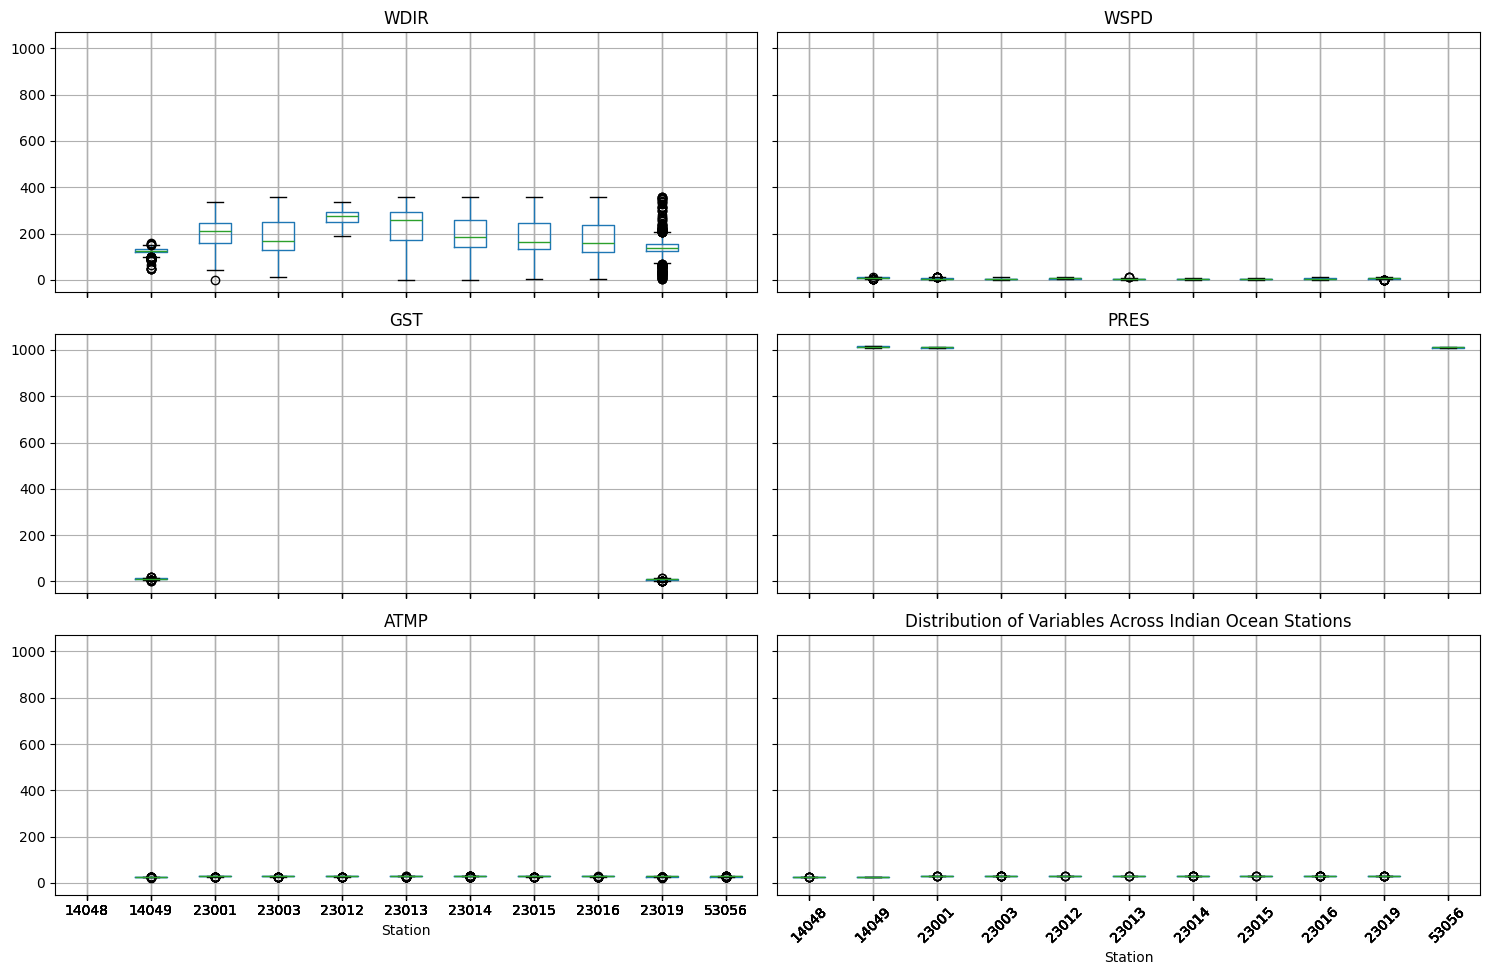

In [13]:
# List of variables that appear to be available
available_variables = ['WDIR', 'WSPD', 'GST', 'PRES', 'ATMP', 'WTMP']

# Combine all station data into a single DataFrame
combined_df = pd.concat(station_data_list, keys=indian_ocean_stations)
combined_df = combined_df.reset_index(level=0).rename(columns={'level_0': 'Station'})

# Create a plot for each available variable
for variable in available_variables:
    plt.figure(figsize=(12, 6))
    for station in indian_ocean_stations:
        station_data = combined_df[combined_df['Station'] == station]
        if variable in station_data.columns and not station_data[variable].isna().all():
            plt.plot(station_data.index, station_data[variable], label=station)
    
    plt.title(f'{variable} Over Time for Indian Ocean Stations')
    plt.xlabel('Time')
    plt.ylabel(variable)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Create a boxplot for each available variable
plt.figure(figsize=(15, 10))
combined_df.boxplot(column=available_variables, by='Station', figsize=(15, 10))
plt.title('Distribution of Variables Across Indian Ocean Stations')
plt.suptitle('')  # This removes the automatic suptitle
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
!pip install plotly

Defaulting to user installation because normal site-packages is not writeable


In [15]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [16]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import importlib

# Check if nbformat is installed and up to date
try:
    import nbformat
    from packaging import version
    if version.parse(nbformat.__version__) < version.parse("4.2.0"):
        print("Warning: nbformat version is outdated. Please update it.")
except ImportError:
    print("Warning: nbformat is not installed. Please install it for better rendering.")

# List of variables that appear to be available
available_variables = ['WDIR', 'WSPD', 'GST', 'PRES', 'ATMP', 'WTMP']

# Combine all station data into a single DataFrame
combined_df = pd.concat(station_data_list, keys=indian_ocean_stations)
combined_df = combined_df.reset_index(level=0).rename(columns={'level_0': 'Station'})

# Create an interactive plot for each available variable
for variable in available_variables:
    fig = px.line(combined_df, x=combined_df.index, y=variable, color='Station',
                  title=f'{variable} Over Time for Indian Ocean Stations')
    fig.update_layout(xaxis_title='Time', yaxis_title=variable)
    
    # Use offline plotting as a workaround
    try:
        fig.show()
    except Exception as e:
        print(f"Error showing plot: {e}")
        print("Attempting to use offline plotting...")
        import plotly.offline as pyo
        pyo.plot(fig, filename=f'{variable}_plot.html')

# Create an interactive boxplot for each available variable
fig = make_subplots(rows=2, cols=3, subplot_titles=available_variables)

for i, variable in enumerate(available_variables):
    row = i // 3 + 1
    col = i % 3 + 1

    box_trace = go.Box(y=combined_df[variable], x=combined_df['Station'], name=variable)
    fig.add_trace(box_trace, row=row, col=col)

fig.update_layout(height=800, width=1200, title_text='Distribution of Variables Across Indian Ocean Stations')

# Use offline plotting for the boxplot as well
try:
    fig.show()
except Exception as e:
    print(f"Error showing boxplot: {e}")
    print("Using offline plotting for boxplot...")
    pyo.plot(fig, filename='boxplot.html')



# Make music out of it

Ok, now lets make music out of it.

## Limitations:
Each instrument in the BBC has a different range. So Piano has all the range, but violins have different ranges, so their should be a way to map them to get the output sound desired

## Initial Features:
- The range will be 3 octaves
- In each parameter, a min an a max will be decided, and then all the data will be calculated around those numbers
- A function will take those bases notes and assign key and music mode (lydian, mixolidian, etc)


### Ranges:
- Wind direction: 0 to 360
- Wind speed: 0 to 14
- Wind Gust: 2 to 16
- Pressure: 1006 1018
- Air temperature 24 to 30
- Water temperature 26 to 31
 

In [35]:
variable_ranges = {
    'WDIR': (0, 360),    # Wind direction in degrees
    'WSPD': (0, 14),     # Wind speed in m/s (adjust max as needed)
    'GST': (2, 16),      # Wind gust speed in m/s (adjust max as needed)
    'PRES': (1006, 1018), # Atmospheric pressure in hPa
    'ATMP': (24, 30),   # Air temperature in °C
    'WTMP': (26, 31)     # Water temperature in °C
}

In [26]:
## Remove unused variables from the availability dataframe

print(availability)

availability = availability[available_variables]
print(availability)


       WDIR  WSPD  GST  PRES  ATMP  WTMP
14048     0     0    0     0     0     1
14049     1     1    1     1     1     1
23001     1     1    0     1     1     1
23003     1     1    0     0     1     1
23012     1     1    0     0     1     1
23013     1     1    0     0     1     1
23014     1     1    0     0     1     1
23015     1     1    0     0     1     1
23016     1     1    0     0     1     1
23019     1     1    1     0     1     1
53056     0     0    0     1     1     0
       WDIR  WSPD  GST  PRES  ATMP  WTMP
14048     0     0    0     0     0     1
14049     1     1    1     1     1     1
23001     1     1    0     1     1     1
23003     1     1    0     0     1     1
23012     1     1    0     0     1     1
23013     1     1    0     0     1     1
23014     1     1    0     0     1     1
23015     1     1    0     0     1     1
23016     1     1    0     0     1     1
23019     1     1    1     0     1     1
53056     0     0    0     1     1     0


Let's start with wind direction.
- Filter only stations wih wind direction
- normalize teh data based on the selected range
- turn into 3 octaves
- The data would be ready to go go through other process (like tune it into a mode/scale)

In [22]:


print(indian_ocean_stations[station_index])
print(station_data_list[station_index].head())


14048
                     WDIR  WSPD  GST  WVHT  DPD  APD  MWD  PRES  ATMP  WTMP  \
timestamp                                                                     
2024-07-31 00:00:00   NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN  27.3   
2024-07-31 01:00:00   NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN  27.3   
2024-07-31 02:00:00   NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN  27.2   
2024-07-31 03:00:00   NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN  27.3   
2024-07-31 04:00:00   NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN  27.2   

                     DEWP  VIS  PTDY  TIDE  
timestamp                                   
2024-07-31 00:00:00   NaN  NaN   NaN   NaN  
2024-07-31 01:00:00   NaN  NaN   NaN   NaN  
2024-07-31 02:00:00   NaN  NaN   NaN   NaN  
2024-07-31 03:00:00   NaN  NaN   NaN   NaN  
2024-07-31 04:00:00   NaN  NaN   NaN   NaN  


In [32]:
indian_ocean_dict = {station: data for station, data in zip(indian_ocean_stations, station_data_list)}
indian_ocean_dict

{'14048':                      WDIR  WSPD  GST  WVHT  DPD  APD  MWD  PRES  ATMP  WTMP  \
 timestamp                                                                     
 2024-07-31 00:00:00   NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN  27.3   
 2024-07-31 01:00:00   NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN  27.3   
 2024-07-31 02:00:00   NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN  27.2   
 2024-07-31 03:00:00   NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN  27.3   
 2024-07-31 04:00:00   NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN  27.2   
 ...                   ...   ...  ...   ...  ...  ...  ...   ...   ...   ...   
 2024-09-06 20:00:00   NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN  26.9   
 2024-09-06 21:00:00   NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN  26.9   
 2024-09-06 22:00:00   NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN  26.9   
 2024-09-06 23:00:00   NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN  26.9   
 2024-09-07 00:00:00   NaN   Na

In [31]:
indian_ocean_dict['23015']

WDIR  WSPD  GST  WVHT  DPD  APD  MWD  PRES  ATMP  WTMP  \
timestamp                                                                      
2024-08-06 12:00:00    NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN  30.4   
2024-08-07 12:00:00    NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN  30.2   
2024-08-07 23:00:00  135.0   1.9  NaN   NaN  NaN  NaN  NaN   NaN  28.9  30.2   
2024-08-08 02:00:00  160.0   3.8  NaN   NaN  NaN  NaN  NaN   NaN  29.1  30.2   
2024-08-08 03:00:00  164.0   3.9  NaN   NaN  NaN  NaN  NaN   NaN  29.2  30.2   
...                    ...   ...  ...   ...  ...  ...  ...   ...   ...   ...   
2024-09-06 12:00:00    NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN  30.2   
2024-09-06 14:00:00   24.0   2.6  NaN   NaN  NaN  NaN  NaN   NaN  29.7  30.4   
2024-09-06 15:00:00    8.0   2.7  NaN   NaN  NaN  NaN  NaN   NaN  29.7  30.3   
2024-09-06 16:00:00    8.0   1.9  NaN   NaN  NaN  NaN  NaN   NaN  29.6  30.2   
2024-09-06 17:00:00   44.0   2.8  NaN   NaN  NaN  NaN  NaN   NaN  29.7  30.2   

                     DEWP  VIS  PTDY  TIDE  
timestamp                                   
2024-08-06 12:00:00   NaN  NaN   NaN   NaN  
2024-08-07 12:00:00   NaN  NaN   NaN   NaN  
2024-08-07 23:00:00   NaN  NaN   NaN   NaN  
2024-08-08 02:00:00   NaN  NaN   NaN   NaN  
2024-08-08 03:00:00   NaN  NaN   NaN   NaN  
...                   ...  ...   ...   ...  
2024-09-06 12:00:00   NaN  NaN   NaN   NaN  
2024-09-06 14:00:00   NaN  NaN   NaN   NaN  
2024-09-06 15:00:00   NaN  NaN   NaN   NaN  
2024-09-06 16:00:00   NaN  NaN   NaN   NaN  
2024-09-06 17:00:00   NaN  NaN   NaN   NaN  

[340 rows x 14 columns]

In [33]:
output_octaves = 3

## Data and variable definition:

- **availability**: is a dataframe that contains the station number/name as row and the name of the variables as columns. each position of the table is binary (1 or 0) that shows if that variable is available for that station.
- **variable_ranges**: is a dictionary that maps each variable to its range. The name of the key is the name of the variable, and the value is a tuple showing the max and the min value in the range
- **indian_ocean_dict**: is a dict that contains the dataframes of the actual data information from all the stations. each row is the timestamp of the data, and the columns represent the name of the variables. when no information is available NaN is present.
- **output_octaves**: and int with the number of octaves desired for the output range. 1 octave is 7 notes, 2 octaves is 14 notes and so on.

The next stage is to have a new dataframe with normalized data. multiply this data with the output_octaves variables and round them to the nearest integer

In [43]:
import pandas as pd
import numpy as np

def create_music_base_dict(ocean_dict, variable_ranges, availability, output_octaves):
    ocean_music_base_dict = {}

    for station in availability.index:
        if station not in ocean_dict:
            continue

        df = ocean_dict[station]
        # Create a copy of the original dataframe, but only with columns in availability
        normalized_df = df[availability.columns].copy()

        for variable in availability.columns:
            if availability.loc[station, variable] == 1:
                if variable not in variable_ranges:
                    print(f"Warning: {variable} not found in variable_ranges. Skipping.")
                    continue

                min_val, max_val = variable_ranges[variable]
                
                # Normalize the data
                normalized_df[variable] = (df[variable] - min_val) / (max_val - min_val)
                
                # Scale to the desired number of octaves
                normalized_df[variable] = normalized_df[variable] * (output_octaves * 7)
                
                # Round to nearest integer, but keep NaN values
                normalized_df[variable] = normalized_df[variable].apply(lambda x: round(x) if pd.notnull(x) else x)

        ocean_music_base_dict[station] = normalized_df

    return ocean_music_base_dict

# Usage
indian_ocean_music_base_dict = create_music_base_dict(indian_ocean_dict, variable_ranges, availability, output_octaves)


In [41]:
indian_ocean_music_base_dict['14048']


WDIR  WSPD  GST  PRES  ATMP  WTMP
timestamp                                             
2024-07-31 00:00:00   NaN   NaN  NaN   NaN   NaN     5
2024-07-31 01:00:00   NaN   NaN  NaN   NaN   NaN     5
2024-07-31 02:00:00   NaN   NaN  NaN   NaN   NaN     5
2024-07-31 03:00:00   NaN   NaN  NaN   NaN   NaN     5
2024-07-31 04:00:00   NaN   NaN  NaN   NaN   NaN     5
...                   ...   ...  ...   ...   ...   ...
2024-09-06 20:00:00   NaN   NaN  NaN   NaN   NaN     4
2024-09-06 21:00:00   NaN   NaN  NaN   NaN   NaN     4
2024-09-06 22:00:00   NaN   NaN  NaN   NaN   NaN     4
2024-09-06 23:00:00   NaN   NaN  NaN   NaN   NaN     4
2024-09-07 00:00:00   NaN   NaN  NaN   NaN   NaN     4

[907 rows x 6 columns]

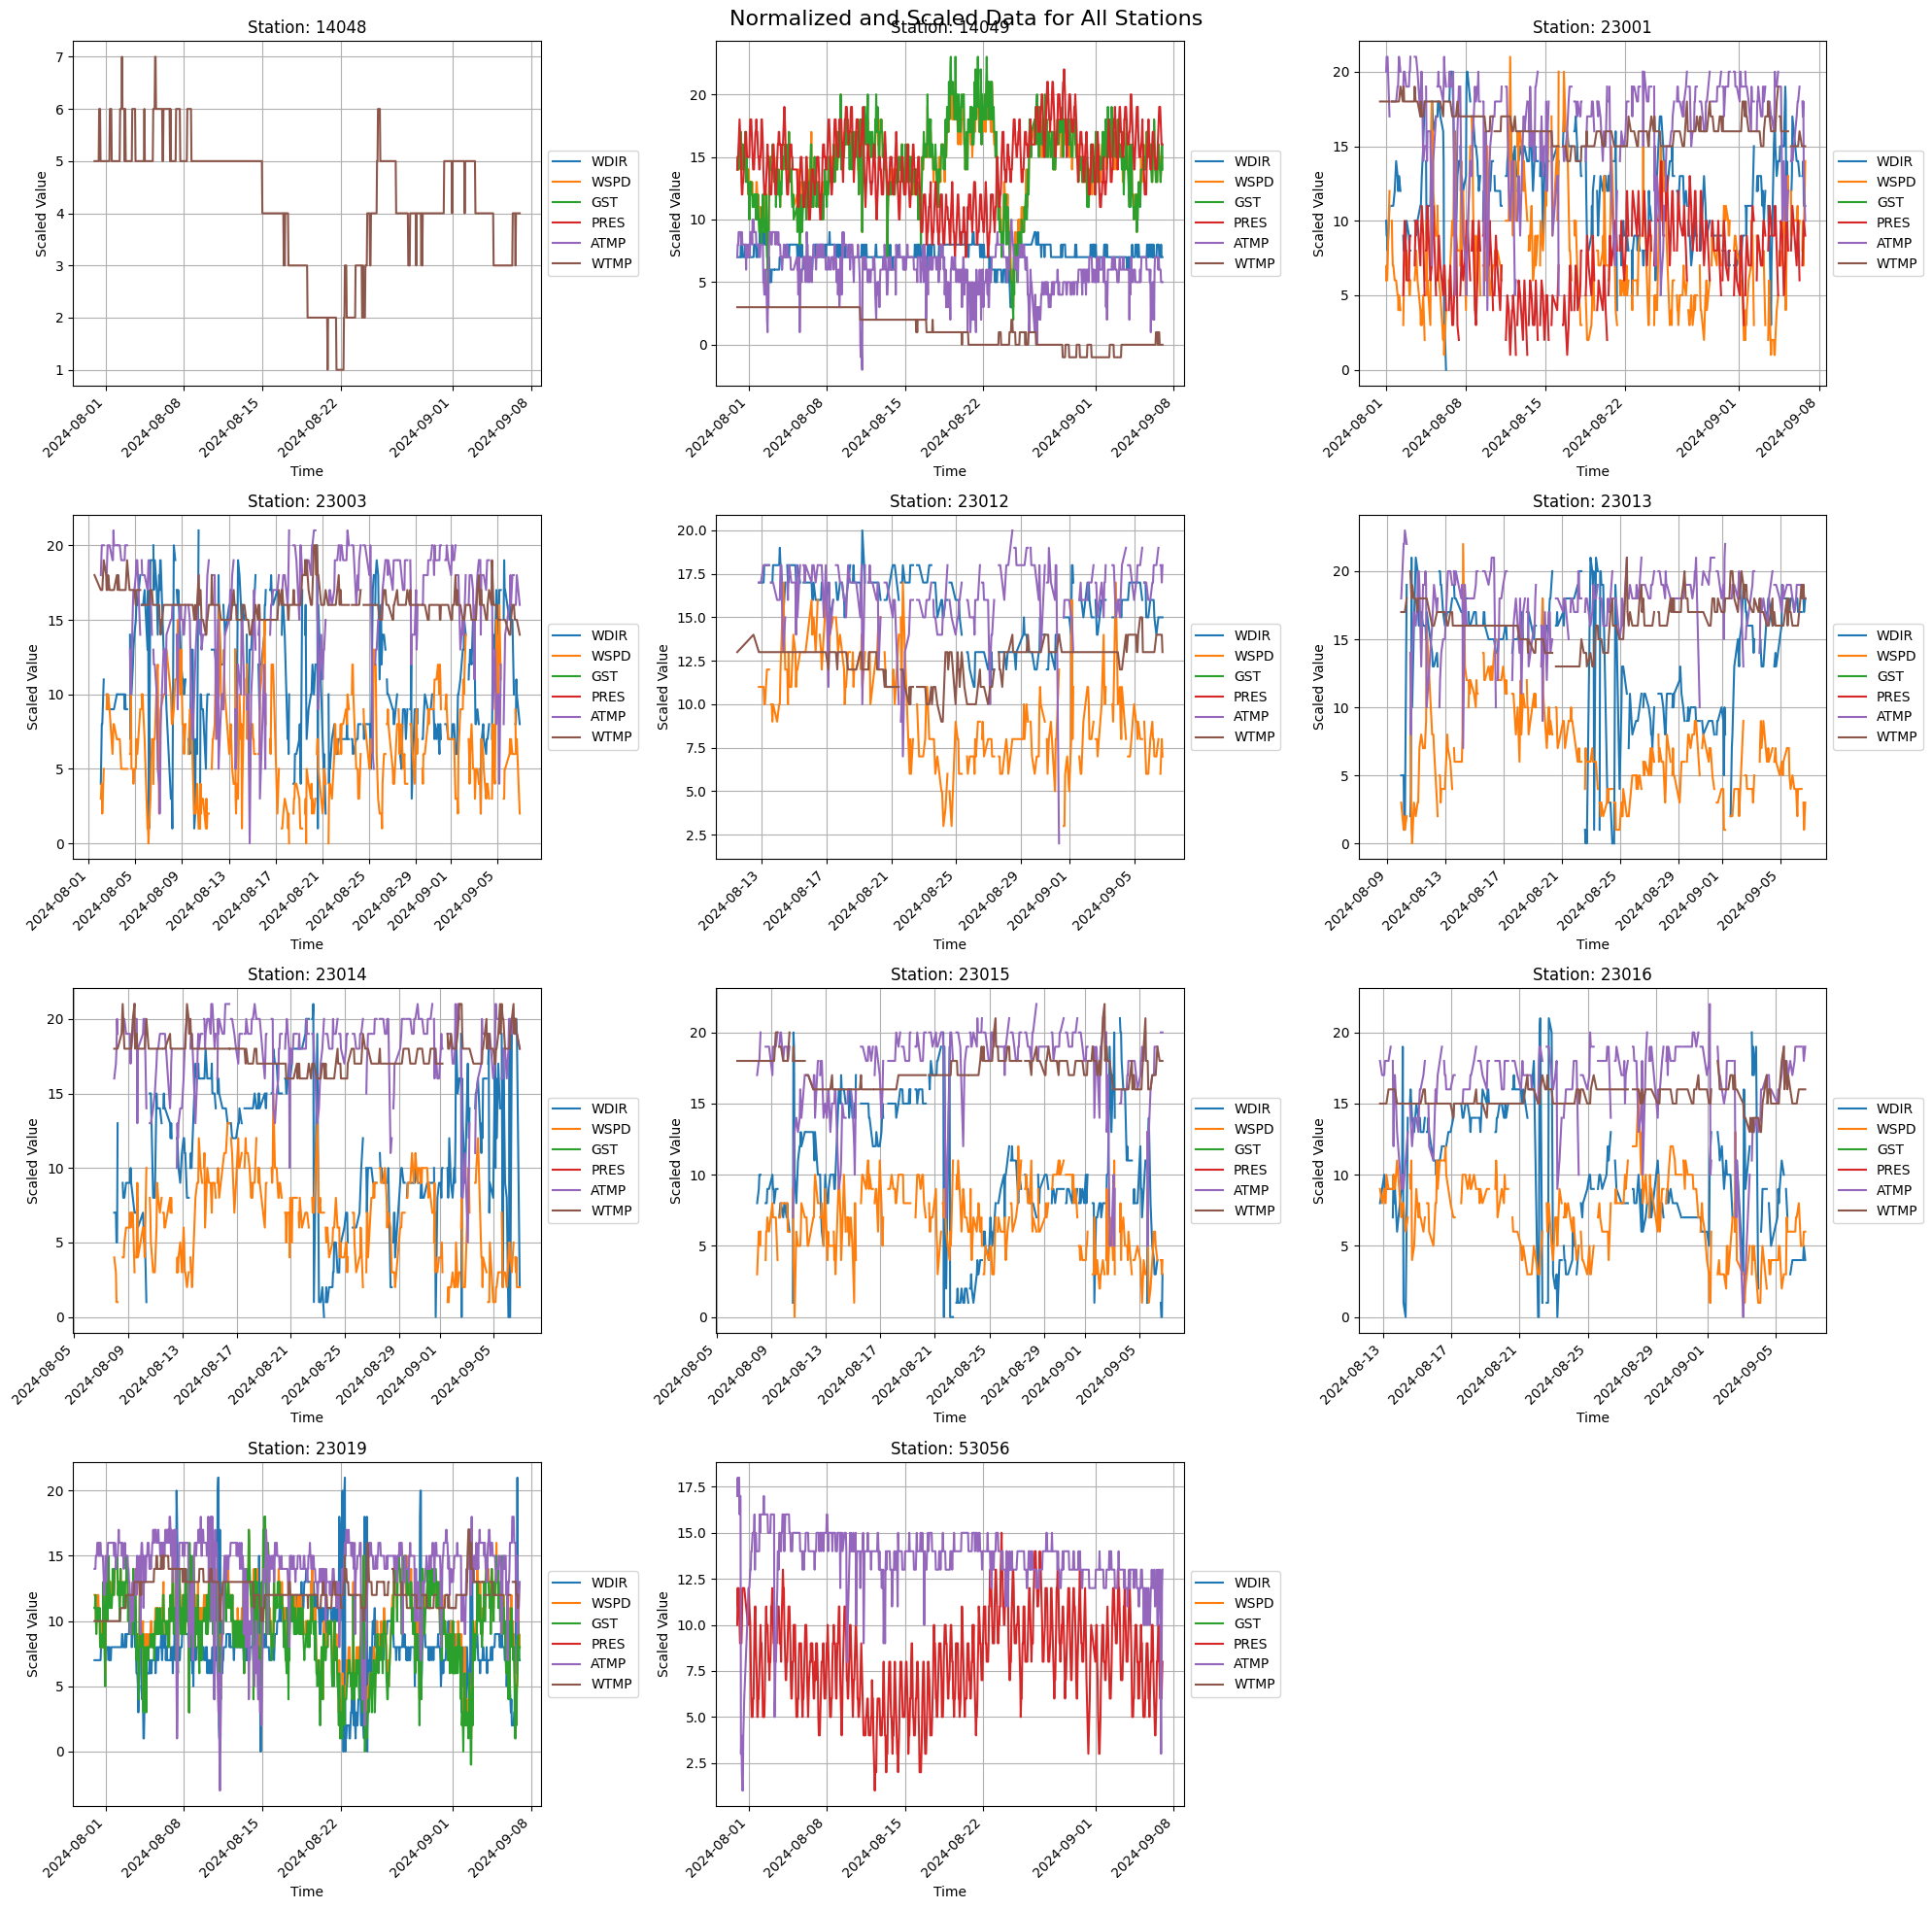

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_music_base_dict(ocean_music_base_dict):
    # Determine the number of stations
    n_stations = len(ocean_music_base_dict)
    
    # Calculate the grid dimensions
    n_cols = 3  # You can adjust this for a different layout
    n_rows = (n_stations - 1) // n_cols + 1

    # Create a new figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    fig.suptitle("Normalized and Scaled Data for All Stations", fontsize=16)

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    for i, (station, df) in enumerate(ocean_music_base_dict.items()):
        ax = axes[i]
        
        # Plot each variable
        for column in df.columns:
            ax.plot(df.index, df[column], label=column)
        
        ax.set_title(f"Station: {station}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Scaled Value")
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.grid(True)

        # Rotate x-axis labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Usage
plot_music_base_dict(indian_ocean_music_base_dict)


For the scope of this notebook. the las thing will be to map this into a specific mode, and play it with different instruments. Station 14049 is the chosen one, as it has all the variables available.

In [45]:
import mido
import time

print("Output ports:", mido.get_output_names())
print("Input ports:", mido.get_input_names())

Output ports: ['Microsoft GS Wavetable Synth 0', 'MPKmini2 1', 'Python2Reaper 2', 'IAC Driver Bus 1 3']
Input ports: ['MPKmini2 0', 'Python2Reaper 1', 'IAC Driver Bus 1 2']


In [47]:
# Define the MIDI port (you may need to adjust this)
port_name = 'IAC Driver Bus 1 3'

# Create a MIDI output
outport = mido.open_output(port_name)

In [51]:
# Define the duration of each note (in seconds)
duration = 0.1

# Get the data for station 14049 from the indian_ocean_music_base_dict
station_data = indian_ocean_music_base_dict['14049']

# Get the variable names
variables = list(station_data.keys())
for index, row in station_data.iterrows():
    print(f"Index: {index}")
    
    for channel, variable in enumerate(variables):
        if pd.notna(row[variable]):  # Check if the value is not NaN
            note = int(row[variable]) + 60  # Adjust the note value as needed
            
            print(f"Variable: {variable}, Note: {note}, Channel: {channel}")
             # Note On message
            msg_on = mido.Message('note_on', note=note, velocity=64, channel=channel)
            outport.send(msg_on)
    
    # Wait for the duration
    time.sleep(duration)
    
    for channel, variable in enumerate(variables):
        if pd.notna(row[variable]):  # Check if the value is not NaN
            note = int(row[variable]) + 60  # Adjust the note value as needed
            
            # Note Off message
            msg_off = mido.Message('note_off', note=note, velocity=64, channel=channel)
            outport.send(msg_off)


Index: 2024-07-31 00:00:00
Variable: WDIR, Note: 67, Channel: 0
Variable: WSPD, Note: 74, Channel: 1
Variable: GST, Note: 74, Channel: 2
Variable: PRES, Note: 74, Channel: 3
Variable: ATMP, Note: 67, Channel: 4
Variable: WTMP, Note: 63, Channel: 5
Index: 2024-07-31 01:00:00
Variable: WDIR, Note: 67, Channel: 0
Variable: WSPD, Note: 75, Channel: 1
Variable: GST, Note: 75, Channel: 2
Variable: PRES, Note: 75, Channel: 3
Variable: ATMP, Note: 68, Channel: 4
Variable: WTMP, Note: 63, Channel: 5
Index: 2024-07-31 02:00:00
Variable: WDIR, Note: 67, Channel: 0
Variable: WSPD, Note: 75, Channel: 1
Variable: GST, Note: 75, Channel: 2
Variable: PRES, Note: 75, Channel: 3
Variable: ATMP, Note: 68, Channel: 4
Variable: WTMP, Note: 63, Channel: 5
Index: 2024-07-31 03:00:00
Variable: WDIR, Note: 67, Channel: 0
Variable: WSPD, Note: 74, Channel: 1
Variable: GST, Note: 74, Channel: 2
Variable: PRES, Note: 76, Channel: 3
Variable: ATMP, Note: 69, Channel: 4
Variable: WTMP, Note: 63, Channel: 5
Index: 2